Use default config for window size n x n and threshold T? [Y/n]: Y

CONFIGURATION:
Window size = 9 x 9
Threshold = 150000


Font 'default' does not have a glyph for '\u684c' [U+684c], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u9762' [U+9762], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u684c' [U+684c], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u9762' [U+9762], substituting with a dummy symbol.


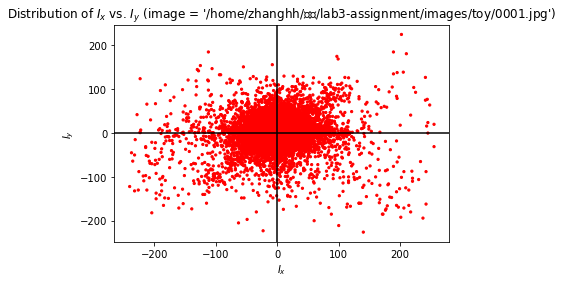

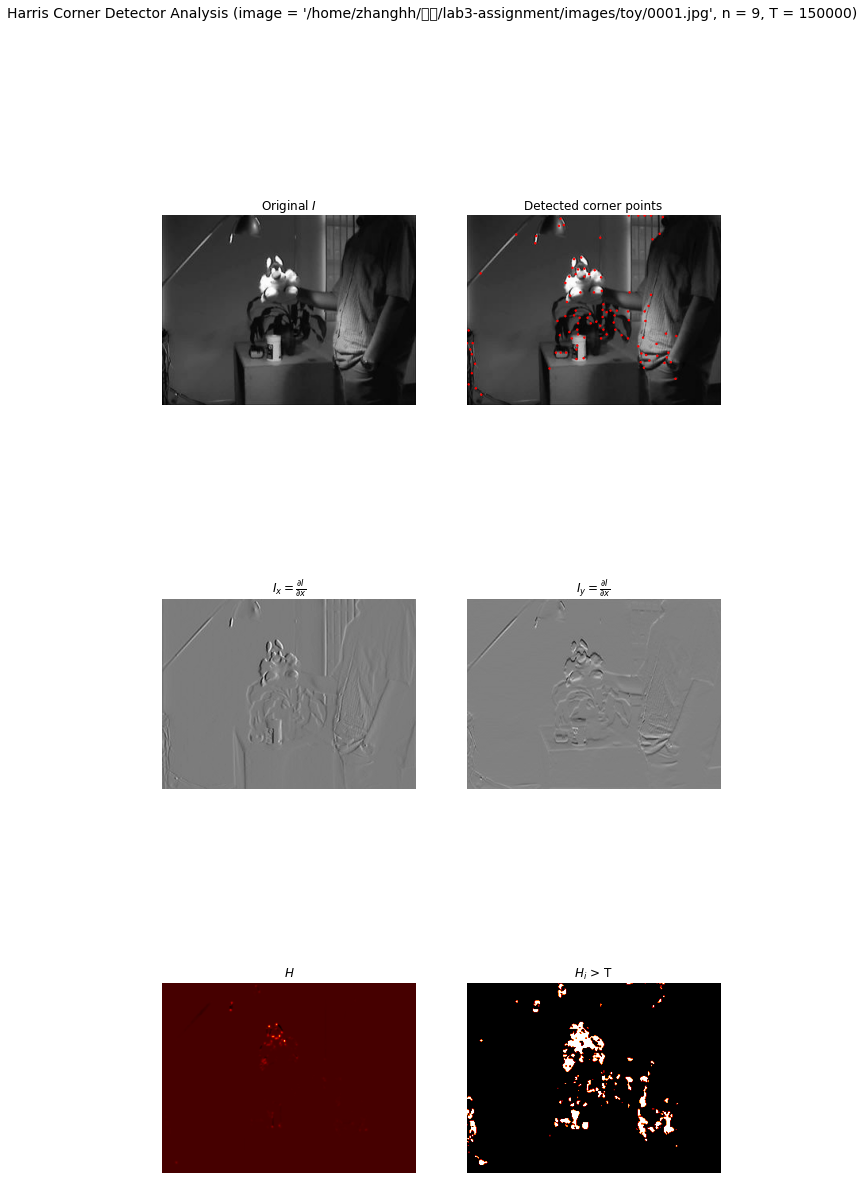

Font 'default' does not have a glyph for '\u684c' [U+684c], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u9762' [U+9762], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u684c' [U+684c], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u9762' [U+9762], substituting with a dummy symbol.


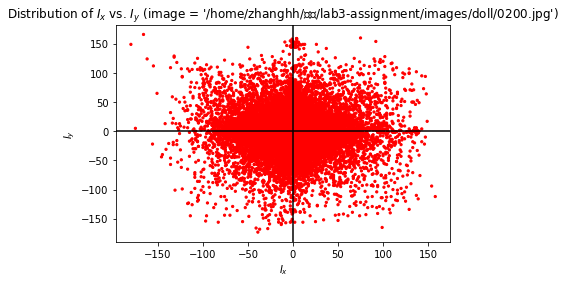

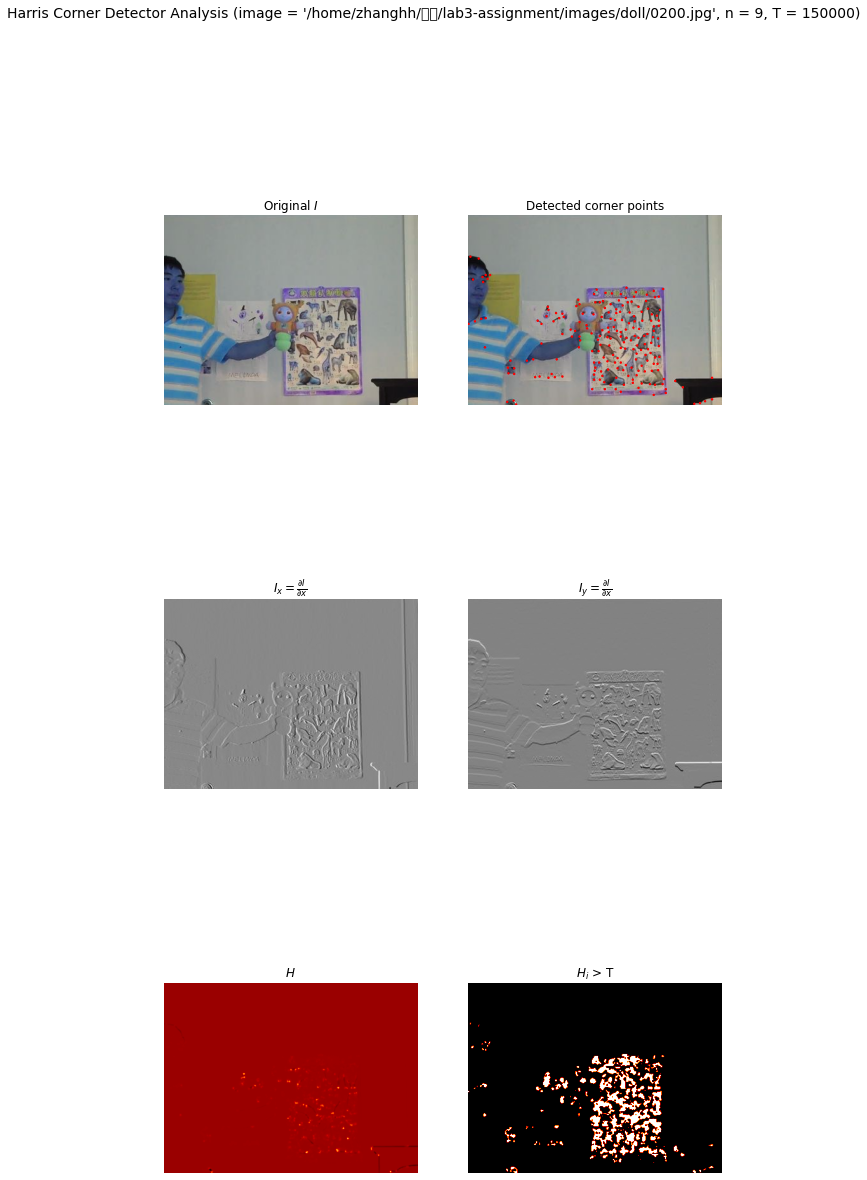

In [3]:
import cv2
import numpy as np
from scipy import signal
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from numpy import linalg as LA, sin

# Compute partial derivative given a kernel
def compute_partial_derivative(I, kernel):    
    return signal.convolve2d(I, kernel, boundary="symm", mode="same") 

# Compute components of Q (see formula assignment)
def compute_Q_components(I_x, I_y):
    # As a rule of thumb the kernel size has to be about 3 times sigma
    # gaussian_filter automatically generates a kernel with a radius of int(truncate * sigma + 0.5) 
    # We want a kernel size 3 since G_d is size 3, so we set sigma to 1
    A = gaussian_filter(I_x ** 2, 1)
    B = gaussian_filter(I_x * I_y, 1)
    C = gaussian_filter(I_y ** 2, 1)

    n = A.shape[0] + B.shape[0]
    m = A.shape[1] + B.shape[1]

    Q = np.array([[A, B],
                [B, C]]).reshape((n, m))

    # Covariance matrix of Q such that it is square
    Q_cov = np.matmul(Q, Q.T)

    #print(LA.eigh(Q_cov))    

    return A, B, C

# Compute H (see formula assignment)
def compute_H(A, B, C):
    H = ((A * C) - (B ** 2)) - 0.04 * ((A + C) ** 2)
    return H

# Detect corners using Harrison Corner algorithm
def detect_corners(H, n, T, surpress = False):
    """
        H:          H image, i.e. raw corner response
        n:          specified window size nxn around a centered pixel located in H    
        T:          user defined threshold
        surpress:   when centered pixel located in H is not peak value surpress it (lowering the value) 
                    or retain it by default by default setting it to False  
    """
    # H = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1],
    #             [8, 8, 8, 8, 8, 8, 8, 8, 8],
    #             [5, 5, 5, 5, 5, 5, 5, 5, 5],
    #             [3, 3, 3, 3, 3, 3, 3, 3, 3]])

    # Handle borders by filling up neighbours out of bounds with zeros
    padding = int((n - 1) / 2)

    # Add vertical padding
    row = np.zeros((padding, H.shape[1]))
    H_pad = np.vstack((row, H, row))

    # Add horizontal padding
    col = np.zeros((H_pad.shape[0], padding))
    H_pad = np.hstack((col, H_pad, col))

    rows, cols = H_pad.shape

    # Indices of corner point
    r = np.empty(0)
    c = np.empty(0)

    # Find local maxima
    for x_i in range(padding, cols - padding):
        for y_i in range(padding, rows - padding):
            # Get neighbourhood patch
            patch = H_pad[y_i - padding : y_i + padding + 1, x_i - padding : x_i + padding + 1]
            patch_flat = patch.flatten()

            # Center point of patch
            center_i = int(patch.size / 2)
            center_val = patch_flat[center_i]

            # Center point's neighbours 
            patch_neighbours = np.delete(patch_flat, center_i)

            # If center value is greater than all its neighbours (in an n × n window centered around this point) 
            # and (2) if it is greater than the user-defined threshold T: mark it as a corner point and retain it
            if all(val < center_val for val in patch_neighbours) and center_val > T:
                r = np.append(r, y_i - padding)
                c = np.append(c, x_i - padding)
            # Surpress it   
            else:
                if surpress:
                    H_pad[y_i][x_i] = 0

    return r, c

# Show distribution of I_x and I_y
def show_relation_Ix_Iy(I_x, I_y, img):
    # Create cluster figure of the relationship between I_x I_y
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.set_title(r"Distribution of $I_x$ vs. $I_y$ (image = '" + img + "')")
    ax1.scatter(I_x.flatten(), I_y.flatten(), s=np.full(I_x.size, 5), color='red')
    ax1.axhline(y=0, color='k')
    ax1.axvline(x=0, color='k')
    ax1.set_xlabel(r'$I_x$')
    ax1.set_ylabel(r'$I_y$')

# Plot relevant result images in figure
def show_image(I, I_x, I_y, H, r, c, n, T, img):
    """
        I:      original input image
        I_x:    partial derivative in x direction of input image
        I_y:    partial derivative in y direction of input image
        r:      row indices of detected corner points
        c:      column indices of detected corner points
        n:      specified window size nxn around a centered pixel located in H
        T:      user defined threshold
        img:    name of image being evaluated
    """

    fig, ((ax_orig, ax_corners), (ax_G_x, ax_G_y), (ax_H1, ax_H2)) = plt.subplots(3, 2, figsize=(10, 20))

    # Original image
    ax_orig.imshow(I, cmap='gray')
    ax_orig.set_title(r'Original $I$')
    ax_orig.set_axis_off()
    
    # Original image with detected corner point
    ax_corners.imshow(I, cmap='gray')
    ax_corners.scatter(c, r, s=np.full(c.size, 2), color='red')
    ax_corners.set_title(r'Detected corner points')
    ax_corners.set_axis_off()

    # H of image
    ax_H1.imshow(H, cmap='gist_heat')
    ax_H1.set_title(r'$H$')
    ax_H1.set_axis_off()
    
    # H with threshold condition
    ax_H2.imshow(H > T, cmap='gist_heat')
    ax_H2.set_title(r'$H_i$ > T')
    ax_H2.set_axis_off()

    # Partial derivative in x-direction
    ax_G_x.imshow(I_x, cmap='gray')
    ax_G_x.set_title(r'$I_x = \frac{\partial I}{\partial x}$')
    ax_G_x.set_axis_off()

    # Partial derivative in y-direction
    ax_G_y.imshow(I_y, cmap='gray')
    ax_G_y.set_title(r'$I_y = \frac{\partial I}{\partial x}$')
    ax_G_y.set_axis_off()

    fig.suptitle(f"Harris Corner Detector Analysis (image = '{img}', n = {n}, T = {T})", fontsize=14)

# Show visual results of Harrison Corner Detector for analyzing
def analyze_harrison_corner_detector(I, I_gray, G_x, G_y, n, T, img):
    """
        I:      original input image
        I_gray: converted to gray input image
        G_x:    kernel to compute derivative in x direction
        G_y:    kernel to compute derivative in y direction
        n:      specified window size nxn around a centered pixel located in H
        T:      user defined threshold
        img:    name of image being evaluated
    """

    # Compute gradient in x-direction
    I_x = compute_partial_derivative(I_gray, G_x)
    # Compute gradient in y-direction
    I_y = compute_partial_derivative(I_gray, G_y)

    A, B, C = compute_Q_components(I_x, I_y)
    H = compute_H(A, B, C)
    r, c = detect_corners(H, n, T)

    # Visualize data
    show_relation_Ix_Iy(I_x, I_y, img)
    show_image(I, I_x, I_y, H, r, c, n, T, img)

# Ask y/n user input
def single_yes_or_no_question(question):
    choices = ' [Y/n]: '
    reply = str(input(question + choices)).lower().strip()
    if reply[0] == 'y' and len(reply) == 1:
        return True
    if reply[0] == 'n' and len(reply) == 1:
        return False
    else:
        return single_yes_or_no_question(question)

if __name__ == "__main__":

    # Manual configuration
    ans = single_yes_or_no_question("Use default config for window size n x n and threshold T?")

    # Use default configuration
    if ans == True:    
        n = 9
        T = 150000
    # Ask user for configuration
    else:
        # Ask user to set window size
        while True:
            try:
                n = int(input("Set window size n x n, with n = "))

                while (n % 2) == 0:  
                    print("Please select a proper window size (must be odd)")
                    n = int(input("Set window size n x n, with n = "))
                break
            except:
                print("That's not a valid window size!")

        # Ask user for threshold
        while True:
            try:
                T = int(input("Define threshold T = "))
                break
            except:
                print("That's not a valid threshold!")

    print("\nCONFIGURATION:")
    print(f"Window size = {n} x {n}")
    print(f"Threshold = {T}")

    # Read in images
    try:
        name = "toy"
        toy_image = cv2.imread('/home/zhanghh/桌面/lab3-assignment/images/toy/0001.jpg') #'./images/test_corner.png')
        toy_image_rgb = cv2.cvtColor(toy_image, cv2.COLOR_BGR2RGB)
        toy_image_gray = cv2.cvtColor(toy_image_rgb, cv2.COLOR_RGB2GRAY)
        toy_image_gray = toy_image_gray.astype(np.float32)
    except:
        print(f"Something went wrong reading the {name} image")
        exit()

    try:
        name = "doll"
        doll_image = cv2.imread('/home/zhanghh/桌面/lab3-assignment/images/doll/0200.jpg')
        doll_image_rgb = cv2.cvtColor(doll_image, cv2.COLOR_BGR2RGB)
        doll_image_gray = cv2.cvtColor(doll_image_rgb, cv2.COLOR_RGB2GRAY)
        doll_image_gray = doll_image_gray.astype(np.float32)
    except:
        print(f"Something went wrong reading the {name} image")
        exit()

    # Kernels to compute gradients along x- and y-axis
    G_x = np.array([[-1, 0, 1]]) # Central difference
    G_y = G_x.T

    # Toy image
    analyze_harrison_corner_detector(toy_image, toy_image_gray, G_x, G_y, n, T, '/home/zhanghh/桌面/lab3-assignment/images/toy/0001.jpg')

    # Doll image
    analyze_harrison_corner_detector(doll_image, doll_image_gray, G_x, G_y, n, T, '/home/zhanghh/桌面/lab3-assignment/images/doll/0200.jpg')

    plt.show()